In [50]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.utils import class_weight
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LeakyReLU, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

from tensorflow import keras
from keras import backend as K
from keras.preprocessing import image
from keras.optimizers import RMSprop, SGD, Adam
from keras.callbacks import ReduceLROnPlateau
from keras.layers import BatchNormalization

In [51]:
# Carreguar o conjunto de treinamento
metadata = pd.read_csv('archive/HAM10000_metadata.csv')

In [52]:
# Examinar a distribuição de classes
class_distribution = metadata['dx'].value_counts()
print(class_distribution)

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


In [53]:
# Remover classe 'nv'
metadata = metadata[metadata['dx'] != 'nv']
# Examinar a distribuição de classes após remoção
class_distribution = metadata['dx'].value_counts()
print(class_distribution)

dx
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


In [54]:
# Pré-processamento dos rótulos (classes)
label_encoder = LabelEncoder()
metadata['encoded_label'] = label_encoder.fit_transform(metadata['dx'])

In [55]:
# Carregar imagens
image_dirs = ['archive/HAM10000_images_part_1', 'archive/HAM10000_images_part_2']

images = [] # Redimensionar

for image_dir in image_dirs:
    for image_id in metadata['image_id']:
        img_path = os.path.join(image_dir, image_id + '.jpg')
        
        if os.path.exists(img_path):  # Verificar se o arquivo existe
            img = load_img(img_path, target_size=(224, 224))
            img_array = img_to_array(img)
            
            img_array /= 255.0 # Normalização dos valores dos pixels (após carregamento)
            
            images.append(img_array)

In [56]:
data_generator = ImageDataGenerator( rotation_range=20,  width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True, zoom_range=0.2, )

In [57]:
X = np.array(images)
X = X / 255.0  # Normalização dos valores dos pixels

# Atualizar os rótulos y para corresponder ao novo DataFrame de metadados
y = to_categorical(metadata['encoded_label'], num_classes=len(label_encoder.classes_))

In [58]:
class_weights = class_weight.compute_class_weight( class_weight='balanced', classes=np.unique(metadata['dx']), y=metadata['dx'] )

In [59]:
class_weight_dict = dict(enumerate(class_weights))



In [60]:
# Dividir o conjunto de dados em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [61]:
data_generator.fit(X) # Aplicar aumento de dados às imagens de treinamento

In [62]:
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='linear', input_shape=(224, 224, 3), kernel_initializer=he_normal())), model.add(LeakyReLU(alpha=0.1)), model.add(MaxPooling2D(pool_size=(2, 2))), model.add(BatchNormalization())

(None, None, None, None)

In [63]:
model.add(Conv2D(128, (3, 3), activation='linear', kernel_initializer=he_normal())) ,model.add(LeakyReLU(alpha=0.1)) ,model.add(MaxPooling2D(pool_size=(2, 2))), model.add(BatchNormalization())

(None, None, None, None)

In [64]:
model.add(Conv2D(256, (3, 3), activation='linear', kernel_initializer=he_normal())), model.add(LeakyReLU(alpha=0.1)), model.add(MaxPooling2D(pool_size=(2, 2))), model.add(BatchNormalization())

(None, None, None, None)

In [65]:
model.add(Flatten())

camada densa de regularização L2

In [66]:
model.add(Dense(256, kernel_regularizer=l2(0.01), activation='linear', kernel_initializer=he_normal())) ,model.add(LeakyReLU(alpha=0.1)) ,model.add(Dropout(0.5)), model.add(BatchNormalization())

(None, None, None, None)

In [67]:
model.add(Dense(128, kernel_regularizer=l2(0.01), activation='linear', kernel_initializer=he_normal())), model.add(LeakyReLU(alpha=0.1)), model.add(Dropout(0.5)) ,model.add(BatchNormalization())

(None, None, None, None)

In [68]:
model.add(Dense(6, activation='softmax'))

In [69]:
base_model = MobileNetV2(weights='imagenet', include_top=False)

In [70]:
x = base_model.output 
x = GlobalAveragePooling2D()(x) 
x = Dense(1024, activation='relu')(x) 
predictions = Dense(len(label_encoder.classes_), activation='softmax')(x)

In [71]:
model = Model(inputs=base_model.input, outputs=predictions)

In [72]:
for layer in base_model.layers: layer.trainable = False

In [73]:
# Carregar o modelo InceptionV3 pré-treinado
base_model = InceptionV3(weights='imagenet', include_top=False)

# Adicionando uma nova camada de saída
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(6, activation='softmax')(x)

# Modelo a ser treinado
model = Model(inputs=base_model.input, outputs=predictions)

# Treinamento apenas das camadas superiores (que foram adicionadas aleatoriamente)
for layer in base_model.layers:
    layer.trainable = False

In [74]:
learning_rate = 0.00001
#optimizer = Adam(learning_rate=learning_rate)
#optimizer = SGD(learning_rate=learning_rate)
optimizer = RMSprop(learning_rate=learning_rate)

In [75]:
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [76]:
# Definição do número de épocas e outros hiperparâmetros de treinamento
num_epochs = 25
batch_size = 32

In [77]:
augmented_data = data_generator.flow(X_train, y_train, batch_size=batch_size)

In [78]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=num_epochs, batch_size=batch_size)

#model.fit(augmented_data, epochs=num_epochs, validation_data=(X_test, y_test)) #MobileNetV2 com aumento de dados
# model.fit(X_train, y_train, validation_data=(X_test, y_test), class_weight=class_weight_dict, epochs=num_epochs, batch_size=batch_size) #MobileNetV2 com pesos
model.fit(augmented_data, epochs=num_epochs, validation_data=(X_test, y_test), class_weight=class_weight_dict) #MobileNetV2 com aumento de dados e pesos

78/78 [==============================] - 166s 2s/step - loss: 1.8317 - accuracy: 0.3461 - val_loss: 1.7047 - val_accuracy: 0.3019


In [83]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=1) 
loss_v, accuracy_v = model.evaluate(X_train, y_train, verbose=1) 
print("Validation: accuracy = %f ; loss_v = %f" % (accuracy_v, loss_v)) 
print("Test: accuracy = %f ; loss = %f" % (accuracy, loss)) 
#plt.plot(history)
y_pred = model.predict(X_test)
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(y_pred, axis=1)

78/78 [==============================] - 109s 1s/step - loss: 1.6965 - accuracy: 0.3477
Validation: accuracy = 0.347703 ; loss_v = 1.696459
Test: accuracy = 0.301932 ; loss = 1.704686
26/26 [==============================] - 33s 1s/step


In [84]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Accuracy: {accuracy * 100:.2f}%')

26/26 [==============================] - 41s 2s/step - loss: 1.7047 - accuracy: 0.3019
Accuracy: 30.19%


In [85]:
precision = precision_score(y_true, y_pred, average='weighted', zero_division=1)

print(f"Precision: {precision * 100:.2f}%")

Precision: 78.92%


In [86]:
recall = recall_score(y_true, y_pred, average='weighted')
print(f"Recall: {recall * 100:.2f}%")

Recall: 30.19%


In [87]:
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"F1-score: {f1 * 100:.2f}%")

F1-score: 14.00%


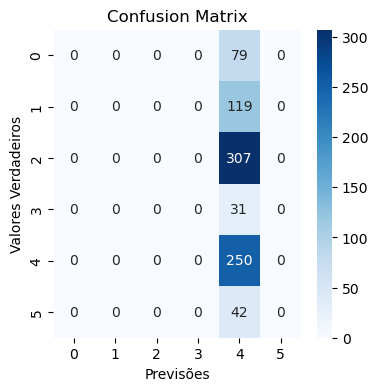

In [88]:
confusion = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(4, 4))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Previsões')
plt.ylabel('Valores Verdadeiros')
plt.title('Confusion Matrix')
plt.show()

In [96]:
model.save('modelo.keras')

In [98]:
# Carregar modelo treinado
model = keras.models.load_model('modelo.keras')
class_names = {
        'mel': 'Melanoma',
        'bkl': 'Lesoes Benignas Semelhantes a Ceratose',
        'bcc': 'Carcinoma de Celulas Basais',
        'akiec': 'Queratoses Actinicas',
        'vasc': 'Lesoes Vasculares',
        'df': 'Dermatofibroma'
    }

1/1 [==============================] - 0s 83ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Resultado da detecção: Carcinoma de Celulas Basais


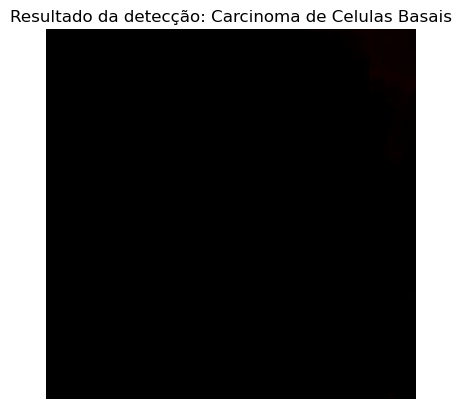

In [109]:
# Implementação da detecção em uma imagem de entrada
def detect_skin_lesion(image_path):
    # Carreguar a imagem de entrada e pré-processe-a
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    #img_array = img_array / 255.0  #CNN # Normalização dos valores dos pixels
    img_array = preprocess_input(img_array) #MobileNetV2
    img_array = np.expand_dims(img_array, axis=0)  # Adicionar uma dimensão extra para corresponder à forma do modelo

    # Fazer uma previsão usando o modelo treinado
    prediction = model.predict(img_array)

    # Decodificar a previsão em uma classe ou rótulo
    predicted_class = label_encoder.inverse_transform([np.argmax(prediction)])[0]
    
    class_name = class_names.get(predicted_class, predicted_class)

    return class_name, img_array

# Exemplo de uso da função de detecção
image_path = 'archive/img2.jpeg'
result, preprocessed_img = detect_skin_lesion(image_path)
print('Resultado da detecção:', result)

# Carreguar e exibir a imagem
plt.imshow(preprocessed_img[0])  # Acessar a primeira imagem no lote (única imagem)
plt.title(f'Resultado da detecção: {result}')
plt.axis('off')  # Desativar os números dos eixos
plt.show()